# **RL DQN Agent for 2048 game**
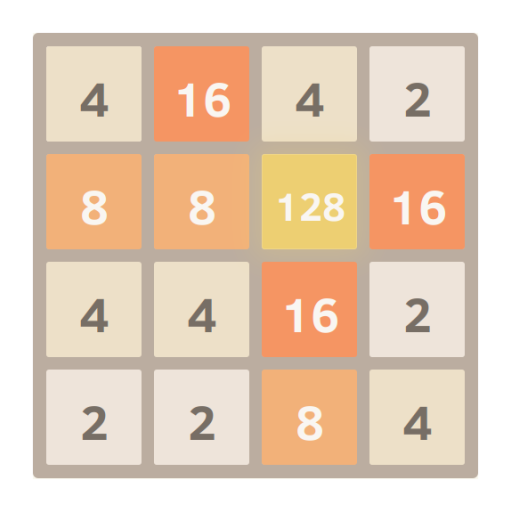
> Submitter name: Bar Vaisman.

> Game logic based on [this environment](https://play2048.co/).

> [Github repository link](https://github.com/bowass/2048-DQN-Agent), including [testing trained agent with GUI](https://github.com/bowass/2048-DQN-Agent/blob/main/2048%20DQN%20Agent.mp4).


# **Dependencies**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import numpy as np
import random
import time

from collections import deque, namedtuple
from itertools import count

from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

In [ ]:
# change to False in order to run on google colab hosted runtime
local_runtime = True

In [ ]:
if local_runtime:
    # local device
    path = '/home/bowass/Documents/school_ml/Models/'
else:
    # drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path = '/content/gdrive/My Drive/RL Project/Models/'

In [ ]:
# use gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# speed up conv. computation
torch.backends.cudnn.benchmark = True

In [ ]:
device

# **Environment**
> 2048 game environments:
*   offline environment ```Env2048```.
*   online environment ```WebEnv2048```.




## *Super-Env*
> Contains functions relevant to both environments.

In [ ]:
class Env(ABC):
    '''
    Super-Environment abstract class.
        - implementations of basic methods relevant to
          both environments (Env2048 and WebEnv2048)
        - declarations of other functions with
          different implementation for each environment  
    '''
    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def step(self, action):
        pass
    
    @abstractmethod
    def score(self):
        pass
    
    @abstractmethod
    def state(self):
        pass

    # returns if the game is over
    def is_done(self):
        if self.empty_tiles() > 0:
            return False
        grid = self.state()
        for i in range(4):
            for j in range(4):
                if  i != 0 and grid[i-1][j] == grid[i][j] or \
                    j != 0 and grid[i][j-1] == grid[i][j]:
                    return False
        return True

    # maximal tile in the current board as a power of 2
    def max_tile(self):
        return 1 << self.state().max()    

    def _can_perform(self, action):
        tmp = np.rot90(self.state(), action)
        for i in range(4):
            empty = False
            for j in range(4):
                empty |= tmp[i, j] == 0
                if tmp[i, j] != 0 and empty:
                    return True
                if j > 0 and tmp[i, j] != 0 and tmp[i, j] == tmp[i, j-1]:
                    return True
        return False
    
    # returns a list of all possible actions
    def possible_actions(self):
        res = []
        for action in range(4):
            if self._can_perform(action):
                res.append(action)
        return res

    # amount of empty tiles in current board
    def empty_tiles(self):
        grid = self.state()
        count = 0
        for i in range(4):
            for j in range(4):
                count += (grid[i, j] == 0)
        return count

## *Offline Environment*
> Fast and recommened for training.


In [ ]:
class Env2048(Env):
	'''
	fast and simple 2048 game enironment.
		- inherits basic methods from Env
		- implements game logic
		- recommended for training, bad UI
	'''
	def __init__(self):
		super().__init__()
		self.grid = np.zeros((4, 4), dtype=int)
		self.add_tile()
		self.add_tile()
		self._score = 0

	def reset(self):
		self.__init__()
		return self.grid

	def add_tile(self):
		# add a new tile (2/4) in a random empty place
		i, j = (self.grid == 0).nonzero()
		rnd = np.random.choice(len(i))
		self.grid[i[rnd], j[rnd]] = np.random.choice([1, 2], p=[0.9, 0.1])

	def step(self, action):
		# rotate the board and step left
		rotated_board = np.rot90(self.grid, action)
		next_state = np.zeros((4, 4), dtype=int)

		# try to merge tiles in each column
		for col_idx in range(4):
			col = rotated_board[col_idx, :]
			result = np.zeros(4, dtype=col.dtype)
			j, prev = 0, None
			for i in range(4):
				if col[i] != 0:
					# move tile to next empty place
					if prev is None:
						prev = col[i]
					# merge tiles
					elif prev == col[i]:
						result[j] = col[i] + 1
						self._score += 1 << result[j]
						j += 1
						prev = None
					else:
						result[j] = prev
						j += 1
						prev = col[i]
			if prev is not None:
				result[j] = prev
			next_state[col_idx] = result

		# rotate back and return to original state
		next_state = np.rot90(next_state, -action)
		if not (next_state == self.grid).all():
			self.grid = next_state
			self.add_tile()

		# returns the reward - #empty tiles
		return self.empty_tiles()

	def score(self):
		return self._score

	def state(self):
		return self.grid

	def render(self):
		print('-'*25)
		for i in range(4):
			for j in range(4):
				print((1 << self.grid[i][j] if self.grid[i][j] != 0 else "0"), end="\t")
			print()
		print('-'*25)

## *Web Environment*
Made with the help of [this repository](https://gist.github.com/pierre-haessig/61d17633940f8edddee1).

> This environment is NOT compatible with google colab.

> In order to use this one run on local runtime.




In [ ]:
# install for the first time
!pip install selenium
!pip install webdriver_manager

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# selenium imports
from selenium.common.exceptions import StaleElementReferenceException
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

In [ ]:
class WebEnv2048(Env):
	'''
	2048 web game enironment.
		- inherits basic methods from Env
		- connects to a web environment
		  and interacts with it
		- recommended for nice testing,
		  but not for training (SLOW)
	'''
	def __init__(self):
		super().__init__()
		url = 'http://gabrielecirulli.github.io/2048/'
		self.driver = webdriver.Chrome(ChromeDriverManager().install())
		self.driver.get(url)
		self.body = self.driver.find_element(By.TAG_NAME, 'body')
	
	def reset(self):
		self.driver.find_element(By.CLASS_NAME, 'retry-button').click()
	
	def state(self):
		try:
			grid = np.zeros((4, 4), dtype=int)
			tiles = self.driver.find_elements(By.CLASS_NAME, 'tile')
   			
			# get grid tiles
			for tile in tiles:
				fields = tile.get_attribute('class').replace('-', ' ').split(' ')
				row, col = int(fields[6]), int(fields[5])
				if len(fields) < 9 or fields[8] != 'merged':
					grid[row - 1][col - 1] += int(fields[2])

			# turn 2^x -> x
			for i in range(4):
				for j in range(4):
					if grid[i][j] != 0:
						grid[i][j] = math.log(grid[i][j], 2)
			return grid
		# if the state isn't loaded yet, try again
		except StaleElementReferenceException:
			return self.state()

	def step(self, action):
		moves = {
			0: Keys.ARROW_LEFT,
			1: Keys.ARROW_UP,
			2: Keys.ARROW_RIGHT,
			3: Keys.ARROW_DOWN
		}
		# move in the corresponding direction
		# and return reward - #empty tiles
		self.body.send_keys(moves[action])
		return self.empty_tiles()
	
	def score(self):
		s = self.body.find_element_by_xpath('/html/body/div[1]/div[1]/div/div[1]').text
		return int(s.split('\n')[0])

# **Model**
> Contains `ReplayMemory` and `DQN` classes. The layout of ```DQN```'s layers was inspired by [this article](https://www.jstage.jst.go.jp/article/ipsjjip/29/0/29_336/_pdf/-char/ja).

In [ ]:
Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'done'))

In [ ]:
class ReplayMemory(object):
    '''
    Experience replay memory for DQN training.
        - a circular array of (using deque) Transitions:
        - each trainsition is a single experience
        - sample random batches from the experiences deque
    '''
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    '''
    DQN model class.
        - contains convolution layers and
          fully-connected layers.
        - returns Q-values for each one
          of the 4 actions (L, U, R, D)
        - both policy and target network
          are instances of this class.
    '''
    def __init__(self):
        super(DQN, self).__init__()
        
        # first layer conv. layers, recieve one-hot
        # encoded (16, 4, 4) array as input
        self.conv1 = nn.Conv2d(16, 128, kernel_size=(1,2))
        self.conv2 = nn.Conv2d(16, 128, kernel_size=(2,1))

        # second layer conv. layers, recieve first layer as input
        self.conv11 = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv12 = nn.Conv2d(128, 128, kernel_size=(2,1))
        self.conv21 = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv22 = nn.Conv2d(128, 128, kernel_size=(2,1))
        
        # flattened shape
        first_layer = 4*3*128*2
        second_layer = 2*4*128*2 + 3*3*128*2
        self.fc = nn.Sequential(
            nn.Linear(first_layer + second_layer, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = x.to(device)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x))
        
        x11 = F.relu(self.conv11(x1))
        x12 = F.relu(self.conv12(x1))
        x21 = F.relu(self.conv21(x2))
        x22 = F.relu(self.conv22(x2))
        
        # flatten and concat layers, input for linear layer
        s1 = x1.shape
        s2 = x1.shape
        
        s11 = x11.shape
        s12 = x12.shape
        s21 = x21.shape
        s22 = x22.shape
        
        x1 = x1.view(s1[0], s1[1]*s1[2]*s1[3])
        x2 = x2.view(s2[0], s2[1]*s2[2]*s2[3])

        x11 = x11.view(s11[0], s11[1]*s11[2]*s11[3])
        x12 = x12.view(s12[0], s12[1]*s12[2]*s12[3])
        x21 = x21.view(s21[0], s21[1]*s21[2]*s21[3])
        x22 = x22.view(s22[0], s22[1]*s22[2]*s22[3])
        
        concat = torch.cat((x1,x2,x11,x12,x21,x22), dim=1)
        return self.fc(concat)

In [ ]:
from torchsummary import summary
summary(DQN().to(device), (16, 4, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 4, 3]           4,224
            Conv2d-2            [-1, 128, 3, 4]           4,224
            Conv2d-3            [-1, 128, 4, 2]          32,896
            Conv2d-4            [-1, 128, 3, 3]          32,896
            Conv2d-5            [-1, 128, 3, 3]          32,896
            Conv2d-6            [-1, 128, 2, 4]          32,896
            Linear-7                  [-1, 256]       1,900,800
              ReLU-8                  [-1, 256]               0
            Linear-9                    [-1, 4]           1,028
Total params: 2,041,860
Trainable params: 2,041,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 7.79
Estimated Total Size (MB): 7.85
---------------------------------------

# **Train**
> training functions and process with the help of [this turorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

## *Utils*
> hyperparameters, variables and auxiliary functions.

In [ ]:
# hyperparameters
BATCH_SIZE = 128      # batch size sampled from memory
GAMMA = 0.99          # discount rate
EPS_START = 0.1       # initial epsilon
EPS_END = 0.0001      # final epsilon
BUFFER_SIZE = 50000   # replay memory size
UPDATE_RATE = 10      # rate of policy updates to target
LEARNING_RATE = 1e-4  # learning rate alpha
DECAY = 10000         # epsilon decay

In [ ]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [ ]:
memory = ReplayMemory(BUFFER_SIZE)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
steps_done = 0

In [ ]:
epsilon = EPS_START

In [ ]:
# save training results
episode_durations = []
scores = []
max_tiles = []

In [ ]:
def one_hot_encode(state):
    '''
    one-hot encode (4, 4) numpy array to (16, 4, 4) numpy array
        - each channel 0..15 is a (4, 4) numpy array,
        - conatins 1's where original grid contains 2^i
          (first channel refers for empty tiles) 
    '''
    result = np.zeros((1, 16, 4, 4), dtype=np.float32)
    for i in range(4):
        for j in range(4):
            result[0][state[i][j]][i][j] = 1.0
    return result

In [ ]:
def select_action(state, possible_actions, train=True):
    # epsilon-greedy
    global epsilon
    state = torch.from_numpy(state).to(device)
    # explore
    if random.random() < epsilon and train:
        return np.random.choice(possible_actions)
    # exploit
    actions = policy_net(state).argsort()[0].cpu().numpy()[::-1]
    for action in actions:
        if action in possible_actions:
            return action
    raise ValueError()

## *Train Functions*
> ```optimize_model``` implements a single round of backprop.

> ```train``` contains the main training loop.


In [ ]:
def optimize_model():
    global steps_done, epsilon
    if len(memory) < BATCH_SIZE:
        return
    steps_done += 1
    # update target to policy if needed
    if steps_done % UPDATE_RATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # sample batch from memory
    batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*memory.sample(BATCH_SIZE))
	
    batch_state = torch.FloatTensor(np.array(batch_state)).squeeze(1).to(device)
    batch_next_state = torch.FloatTensor(np.array(batch_next_state)).squeeze(1).to(device)
    batch_action = torch.Tensor(batch_action).unsqueeze(1).to(device)
    batch_reward = torch.Tensor(batch_reward).unsqueeze(1).to(device)
    batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)
 
    # compute loss & optimize model
    # next states are relevant only if game isn't done
    with torch.no_grad():
        next_q_vals = target_net(batch_next_state)
        y = batch_reward + (1 - batch_done) * GAMMA * torch.max(next_q_vals, dim=1, keepdim=True)[0]
    
    loss = F.mse_loss(policy_net(batch_state).gather(1, batch_action.long()), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # decrease epsilon
    if epsilon > EPS_END:
        epsilon -= (EPS_START - EPS_END) / DECAY

In [ ]:
def train(env: Env, episodes=3000, save_rate=100, print_rate=100):
    global steps_done, epsilon
    start_time = time.time()
    for episode in range(episodes):
        state = one_hot_encode(env.reset())
        for t in count():
            # select and make a single action
            action = select_action(state, env.possible_actions())
            reward = env.step(action)
            next_state = one_hot_encode(env.state())
            done = env.is_done()

            # add experience to memory and optimize
            memory.push(state, next_state, torch.FloatTensor([[action]]).to(device), torch.FloatTensor([[reward]]).to(device), torch.FloatTensor([[done]]).to(device))
            optimize_model()

            state = next_state
            if done:
                episode_durations.append(t + 1)
                scores.append(env.score())
                max_tiles.append(env.max_tile())
                break
        
        # save model weights
        if episode % save_rate == 0:
            torch.save(policy_net.state_dict(), path + 'policy_net.pth')
            torch.save(target_net.state_dict(), path + 'target_net.pth')
        
        # show current progress
        if episode % print_rate == 0:
            env.render()
            print(f'episode {episode} | score {scores[-1]} | max {max_tiles[-1]} | steps {episode_durations[-1]} | time {time.time()-start_time}')
    print("Training Completed.")

## *Train Agent*
> training process with ```Env2048``` & plotted results.



In [ ]:
env = Env2048()

In [ ]:
train(env)

4	2	8	16	
2	4	16	32	
4	16	256	2	
8	64	2	8	
episode 0 | score 2364 | max 256 | steps 200 | time 1.3449816703796387
16	2	4	32	
8	64	256	4	
4	8	64	128	
2	4	32	2	
episode 100 | score 3444 | max 256 | steps 286 | time 267.9054448604584
2	4	8	32	
8	16	64	512	
4	32	2	128	
2	4	8	32	
episode 200 | score 5480 | max 512 | steps 378 | time 652.9211304187775
2	16	8	64	
4	8	16	128	
2	4	64	512	
4	8	32	64	
episode 300 | score 5912 | max 512 | steps 417 | time 1137.7455298900604
2	4	8	64	
8	16	32	128	
4	64	512	2	
2	8	32	64	
episode 400 | score 6032 | max 512 | steps 435 | time 1735.8842027187347
2	8	16	32	
4	16	32	128	
8	4	64	256	
4	2	16	512	
episode 500 | score 7240 | max 512 | steps 505 | time 2402.364599943161
4	2	4	64	
8	32	64	256	
4	2	16	512	
2	4	2	64	
episode 600 | score 6884 | max 512 | steps 475 | time 3076.522155046463
2	8	32	64	
4	16	64	1024	
8	64	128	256	
4	2	32	128	
episode 700 | score 13528 | max 1024 | steps 836 | time 3807.831784248352
2	4	32	128	
8	16	128	512	
16	4	32	64	
4	2	16	32	
epi

In [ ]:
torch.save(policy_net.state_dict(), path + 'policy_net.pth')
torch.save(target_net.state_dict(), path + 'target_net.pth')

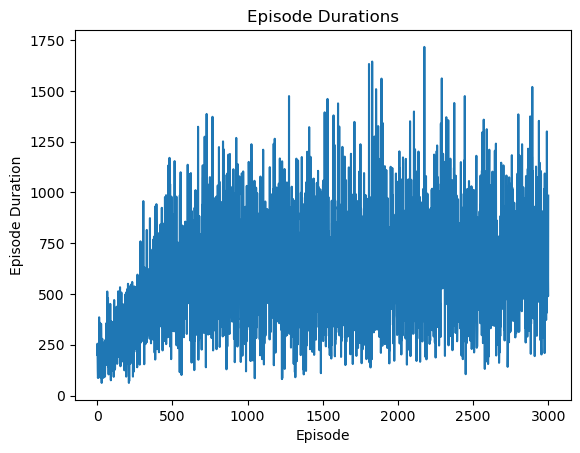

In [ ]:
plt.plot(episode_durations, label='test')
plt.xlabel('Episode')
plt.ylabel('Episode Duration')
plt.title('Episode Durations')
plt.show()

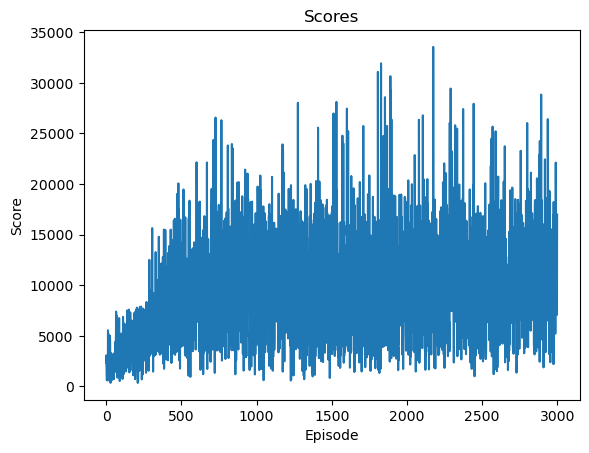

In [ ]:
plt.plot(scores, label='test')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores')
plt.show()

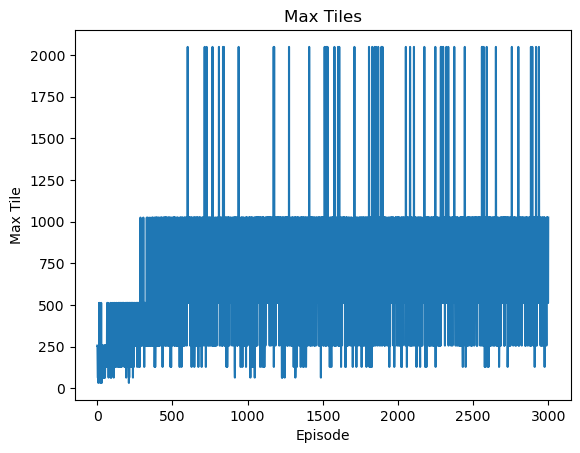

In [ ]:
plt.plot(max_tiles, label='test')
plt.xlabel('Episode')
plt.ylabel('Max Tile')
plt.title('Max Tiles')
plt.show()

# **Test**
> test the trained agent.

## *Test Functions*
> ```select_action_test``` and ```test_single_game``` do precisly what you think they do.

> ```test``` tests the agent for ```episodes``` games.



In [ ]:
def select_action_test(state, possible_actions):
    '''
    selects action with target, exploit only
    '''
    state = torch.from_numpy(state).to(device)
    actions = target_net(state).argsort()[0].cpu().numpy()[::-1]
    for action in actions:
        if action in possible_actions:
            return action
    raise ValueError()

In [ ]:
def test_single_game(env):
    '''
    test a single game of trained agent.
        - select action with target, no exploration
        - returns episode duration, score and max tile
    '''
    for t in count():
        env.step(select_action(one_hot_encode(env.state()), env.possible_actions(), False))
        if env.is_done():
            return t, env.score(), env.max_tile()

In [ ]:
def test(env, episodes=1000):
    '''
    test agent for some episodes.
    returns lists of episode durations, scores and max tiles
    '''
    episode_durations_test = []
    scores_test = []
    max_tiles_test = []
    for episode in range(episodes):
        t, score, max_tile = test_single_game(env)
        episode_durations_test.append(t + 1)
        scores_test.append(score)
        max_tiles_test.append(max_tile)
        env.reset()
    return episode_durations_test, scores_test, max_tiles_test

## *Test Agent*

In [ ]:
# load from path (local / drive)
target_net.load_state_dict(torch.load(path + 'target_net.pth', map_location=device))

### Test with ```Env2048```

In [ ]:
test_env = Env2048()

In [ ]:
episode_durations_test, scores_test, max_tiles_test = test(test_env, episodes=10)

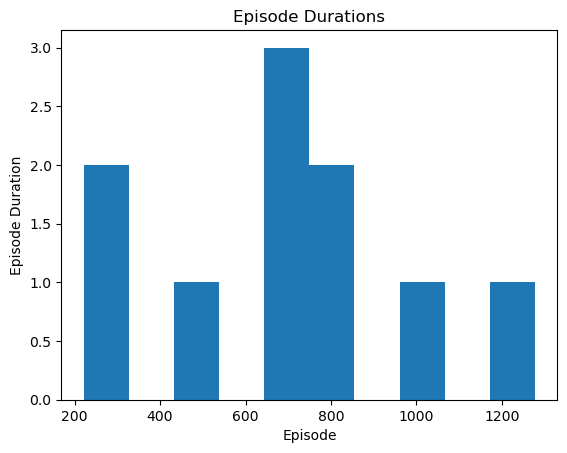

In [ ]:
plt.hist(episode_durations_test, label='test')
plt.xlabel('Episode')
plt.ylabel('Episode Duration')
plt.title('Episode Durations')
plt.show()

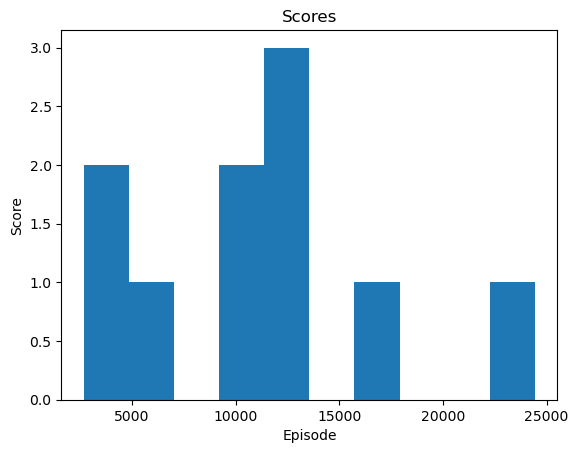

In [ ]:
plt.hist(scores_test, label='test')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores')
plt.show()

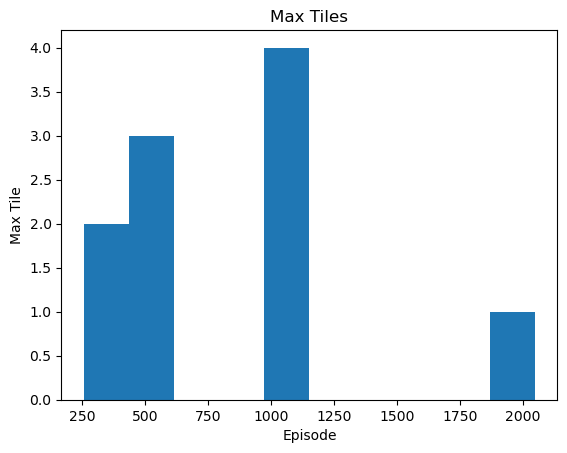

In [ ]:
plt.hist(max_tiles_test, label='test')
plt.xlabel('Episode')
plt.ylabel('Max Tile')
plt.title('Max Tiles')
plt.show()

### Test with ```WebEnv2048```

In [ ]:
# connect to web environment - make
# sure it's loaded before testing
web_env = WebEnv2048()

In [ ]:
test_single_game(web_env)